In [163]:
import warnings
import pandas as pd 
import numpy as np
from scipy.spatial import distance
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

In [164]:
warnings.simplefilter('ignore')

In [165]:
#Read the file
def read_file(filename): 
    data = pd.read_csv("data/" + filename + ".csv") 
    data.head()
    return data

In [166]:
def data_preprocessing(data):
    data = data.rename(columns={"Churn": "churn"})
    drop_unique_col = ["state", "phone number", "area code", "customerID", "Customer_ID"]
    for col in drop_unique_col:
        if col in data.columns:
            data = data.drop([col], axis = 1)
    for col in data.columns:
        data[col].replace("yes", True, inplace=True)
        data[col].replace("no", False, inplace=True)
        data[col].replace("Yes", True, inplace=True)
        data[col].replace("No", False, inplace=True)
        if(data[col].dtype == object):     
            data = pd.concat([data,pd.get_dummies(data[col], prefix=col)],axis=1)
            data = data.drop([col], axis = 1)
        elif(data[col].dtype == bool):
            data[col].replace(True, 1, inplace=True)
            data[col].replace(False, 0, inplace=True)
        else:
            data[col] = pd.cut(data[col],10,right=True,labels=[0,1,2,3,4,5,6,7,8,9])   
    #data.head()
    #data.groupby('churn').count() 
    return data

In [167]:
# Compute the Distance Matrix
def distance_matrix(data, dist_type):
    matrix = distance.cdist(data.iloc[:,:-1],data.iloc[:,:-1], dist_type)
    distanceMatrix = pd.DataFrame(matrix)
    return distanceMatrix

In [168]:
def plot_distance_matrix(distanceMatrix):
    width_in_inches = 2
    height_in_inches = 2
    dots_per_inch = 70
    plt.figure(figsize=(width_in_inches, height_in_inches),dpi=dots_per_inch)
    distanceMatrix = np.array(distanceMatrix)
    length = distanceMatrix.shape[0]
    width = distanceMatrix.shape[1]
    x, y = np.meshgrid(np.arange(length), np.arange(width))
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.plot_surface(x, y, distanceMatrix)
    plt.show()

In [169]:
# Gaussian Naive Bayes Classifier
def classification(data, classifier_type):
    if(classifier_type == 'Gaussian'):
        clf = GaussianNB()
        
    if(classifier_type == 'GBC'):
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
              
        
    results = []
    features = list(data.columns)
    features.remove('churn')
    features.remove('distance')

    for zoneLength in range(100,1001,100):
    
        LDT = data[0:zoneLength]
        UDT = data[-zoneLength:]
        trainingData = data[zoneLength:-(zoneLength)]
    
        X = trainingData.loc[:,features]
        Y = trainingData.loc[:,['churn']]
        clf.fit(X,Y)
    
        LDT_x = LDT.loc[:,features]
        LDT_y = LDT.loc[:,['churn']]
        prediction = clf.predict(LDT_x)

        LDT_accuracy = accuracy_score(LDT_y, prediction) * 100
        LDT_precision = precision_score(LDT_y, prediction) * 100
        LDT_recall = recall_score(LDT_y, prediction) * 100
        LDT_fmeasure = f1_score(LDT_y, prediction) * 100
    
        UDT_x = UDT.loc[:, features]
        UDT_y = UDT.loc[:,['churn']]
        prediction = clf.predict(UDT_x)

        UDT_accuracy = accuracy_score(UDT_y, prediction) *100
        UDT_precision = precision_score(UDT_y, prediction) * 100
        UDT_recall = recall_score(UDT_y, prediction) * 100
        UDT_fmeasure = f1_score(UDT_y, prediction)  * 100
    
        results.append({'zoneLength':zoneLength, 'LDT_accuracy':LDT_accuracy, 'LDT_precision':LDT_precision, 'LDT_recall':LDT_recall, 'LDT_fmeasure': LDT_fmeasure,'UDT_accuracy':UDT_accuracy, 'UDT_precision':UDT_precision, 'UDT_recall':UDT_recall, 'UDT_fmeasure': UDT_fmeasure})
        
    resultsDf = pd.DataFrame(results)
    resultsDf = resultsDf[['zoneLength', 'LDT_accuracy','UDT_accuracy','LDT_precision','UDT_precision','LDT_recall','UDT_recall','LDT_fmeasure','UDT_fmeasure']]
        
    return resultsDf
    

In [170]:
def plot_results(resultsDf):
    
    plt.style.use('seaborn-whitegrid')
        
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(100, 1000, 10)
    ax.plot(x, resultsDf['UDT_accuracy'],color='red',marker='o',label='UDT-Accuracy')
    ax.plot(x, resultsDf['LDT_accuracy'],color='blue',marker='s',label='LDT-Accuracy')
    plt.legend(loc='best')

    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(100, 1000, 10)
    ax.plot(x, resultsDf['UDT_precision'],color='yellow',marker='o',label='UDT-Precision')
    ax.plot(x, resultsDf['LDT_precision'],color='black',marker='s',label='LDT-Precision')
    plt.legend(loc='best')
    
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(100, 1000, 10)
    ax.plot(x, resultsDf['UDT_recall'],color='yellow',marker='o',label='UDT-Recall')
    ax.plot(x, resultsDf['LDT_recall'],color='black',marker='s',label='LDT-Recall')
    plt.legend(loc='best')

    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(100, 1000, 10)
    ax.plot(x, resultsDf['UDT_fmeasure'],color='yellow',marker='o',label='UDT-fmeasure')
    ax.plot(x, resultsDf['LDT_fmeasure'],color='black',marker='s',label='LDT-fmeasure')
    plt.legend(loc='best')



<Figure size 140x140 with 0 Axes>

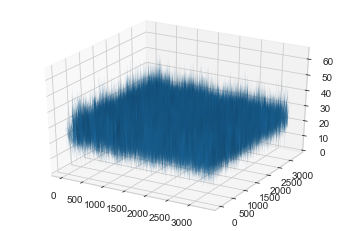

   zoneLength  LDT_accuracy  UDT_accuracy  LDT_precision  UDT_precision  \
0         100     81.000000     91.000000      37.500000      83.333333   
1         200     86.000000     89.500000      44.444444      72.727273   
2         300     88.000000     89.666667      52.173913      70.967742   
3         400     87.750000     88.250000      58.823529      71.428571   
4         500     89.000000     89.000000      64.444444      73.469388   
5         600     88.833333     88.000000      64.912281      68.852459   
6         700     89.000000     88.571429      62.686567      71.794872   
7         800     89.000000     88.000000      61.643836      72.619048   
8         900     89.222222     88.000000      60.240964      69.230769   
9        1000     89.500000     87.400000      63.333333      70.093458   

   LDT_recall  UDT_recall  LDT_fmeasure  UDT_fmeasure  
0   17.647059   58.823529     24.000000     68.965517  
1   30.769231   51.612903     36.363636     60.377358  
2   32

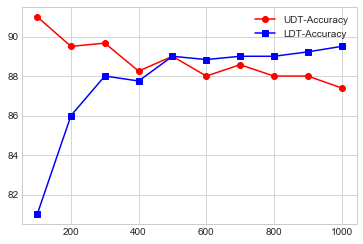

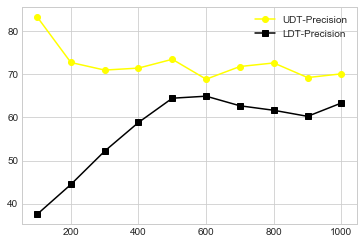

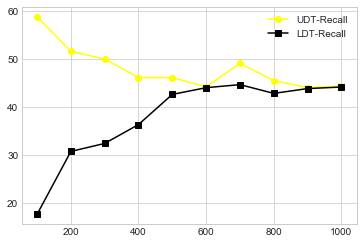

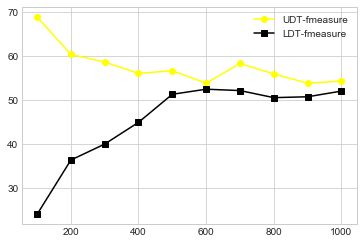

In [171]:
filename = "dataset-1"
distance_metric = 'cityblock'
classifier = 'GBC'

data = read_file(filename)
#print(data)
data = data_preprocessing(data)
#print(data)
distanceMatrix = distance_matrix(data, distance_metric)
#print(distanceMatrix)
plot_distance_matrix(distanceMatrix)

#Append Distance
data.loc[:,'distance'] = distanceMatrix.sum(axis=1)
# Sort the dataset in ascending order of distance
data.sort_values(by=['distance'])

resultsDf = classification(data, classifier)
print(resultsDf)
plot_results(resultsDf)
